# Projet 6 - Classifiez automatiquement des biens de consommation

Le but de ce projet est d'étudier la faisabilité d'un outil de classification automatique d'objets d'une marketplace en vue de faciliter l'expérience utilisateur.

Les données sont à l'adresse https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip

On se basera dans un premier temps sur la description des objets et dans un second temps sur les images associées.

Dans les deux cas on commmencera par réaliser un clustering non supervisé afin de voir si il se forme naturellement des clusters qui regroupent les items selon leurs similitudes, ce qui permettrait de proposer une meilleure catégorisation que celle déjà en place.

Si cette approche ne permet pas de challenger la catégorisation en place on proposera un algorithme de classification permettant une automatisation efficace.

In [141]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from functions import *
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import os
import time

import bokeh
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook

%matplotlib inline

In [2]:
# Version des modules
print('Pandas:', pd.__version__)
print('Matplotlib:', matplotlib.__version__)
print('Numpy:', np.__version__)
print('Seaborn:', sns.__version__)
print('Scikit-learn:', sklearn.__version__)
print('Keras:', keras.__version__)
print('Bokeh:', bokeh.__version__)

Pandas: 1.2.4
Matplotlib: 3.3.4
Numpy: 1.19.5
Seaborn: 0.11.1
Scikit-learn: 0.24.1
Keras: 2.5.0
Bokeh: 2.3.2


In [3]:
sns.set(style='ticks', font_scale=1.4)

In [4]:
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

### Analyse exploratoire

In [5]:
df.shape

(1050, 15)

In [6]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [7]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [8]:
# Exemples de sous-catégories peu efficacement répertoriées
gb = df.groupby(by='product_category_tree').size().sort_values(ascending=False)
gb[gb==1].head()

product_category_tree
["Home Decor & Festive Needs >> Wall Decor & Clocks >> Posters >> Urban Monk Posters >> Bourne Supermacy Canvas Art (18 inch X 12 inch, ..."]             1
["Home Decor & Festive Needs >> Wall Decor & Clocks >> Posters >> Shoperite Posters >> painting_art_couple_love__Dance Paper Print (12 ..."]              1
["Home Decor & Festive Needs >> Wall Decor & Clocks >> Posters >> STYLE CLUES FASHION Posters >> scarlet tanager bird normal POSTER Paper Print (..."]    1
["Home Decor & Festive Needs >> Wall Decor & Clocks >> Paintings >> BRANDWAGON Paintings >> BRANDWAGON DIGIPRINT Digital Reprint Painting (1..."]         1
["Home Furnishing >> Floor Coverings >> Carpets & Rugs >> FURNISHINGLAND Green Silk Carpet (60 cm  X 180 cm)"]                                            1
dtype: int64

In [9]:
len(gb[gb==1])/df['product_category_tree'].nunique()

0.8504672897196262

85% des sous catégories uniques ne contiennent qu'un seul item, ce qui se traduit par une arborescence peu efficace. 

Les vendeurs renseignent probablement à la main la sous-catégorie de dernier niveau, d'où l'intérêt d'une classification automatique en vue de regrouper les items qui peuvent l'être.

In [5]:
def categories(df, level=0, unique=True):
    '''
    Renvoit les (sous)catégories sur
    le niveau renseigné (par défaut le niveau zéro).
    '''
    categories = df['product_category_tree']
    
    # On enlève les charactères en trop
    for w in ['[', ']', '"']:
        categories = categories.str.replace(w, '', regex=False)
        
    categories = categories.apply(lambda x: x.split(' >> ')[level])
    if unique == True:
        categories = categories.unique()
    
    return categories

In [11]:
# Catégories de premier niveau
categories(df)

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [12]:
df['categories'] = categories(df, unique=False)

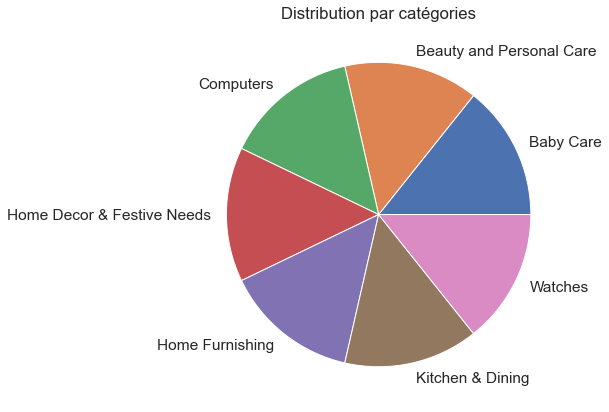

In [13]:
# Distribution des items par catégorie
cat_size = df.groupby(by='categories').size()
cat_size = cat_size.sort_values(ascending=False)
plt.figure(figsize=(15, 7))
plt.title('Distribution par catégories')
plt.pie(cat_size, labels=cat_size.index)
plt.show()

Les catégories de premier niveau sont équitablement représentées.

In [14]:
df['sous-categories'] = categories(df, level=1, unique=False)

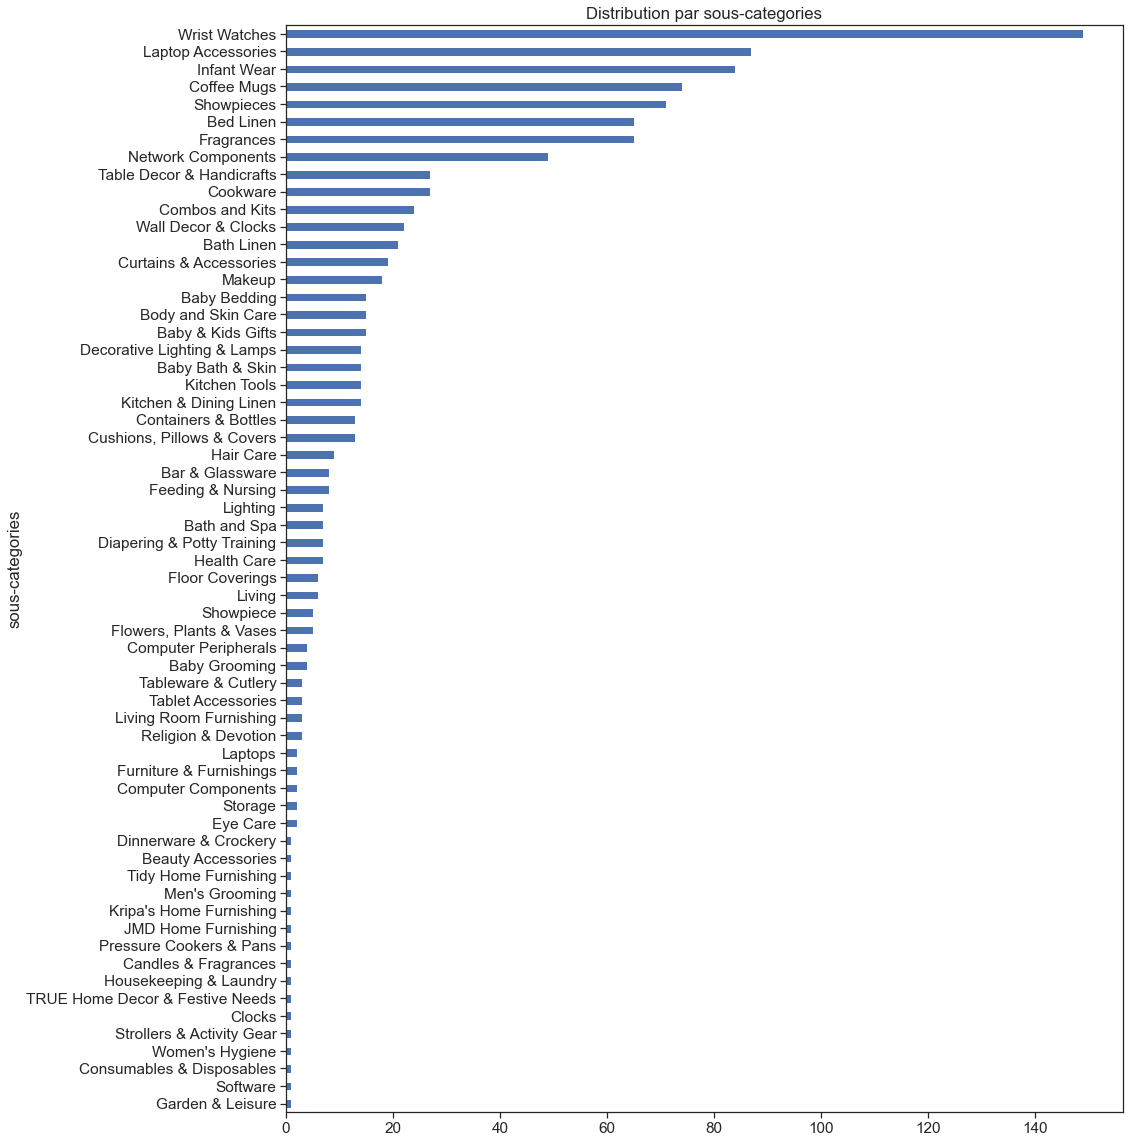

In [15]:
# Distribution des items par catégorie
cat_size = df.groupby(by='sous-categories').size()
cat_size = cat_size.sort_values(ascending=True)
plt.figure(figsize=(15, 20))
plt.title('Distribution par sous-categories')
# plt.barh(cat_size, width=15)
cat_size.plot.barh(title='Distribution par sous-categories')
plt.show()

Par contre on remarque sur le graphe ci-dessus que dès le second niveau, la taille des groupes devient très hétérogène et de nombreuses sous-catégories sont sous-représentées.

Pour répondre à la question de la faisabilité d'une classification automatique, on peut essayer en premier lieu de réaliser un clustering non supervisé afin de voir si on a des clusters qui se forment naturellement et qui permettent un bon découpage des différents items, quitte à revoir la catégorisation déjà existante.

Si ce n'est pas le cas on pourra préférer une approche supervisée afin de classifier automatiquement les items à l'aide des étiquettes déjà existantes (catégories de premier niveau). Les sous-catégories ne peuvent pas être utilisées dans cette approche puisque trop hétérogènes (trop de sous-catégories quasi vides).

## Données texte
### Preprocessing


Le prétraitement des données textes inclue les opérations suivantes: 
- nettoyage du texte (passage en minuscules, nettoyage pnctuation, suppression des stop words)
- fonction de racination (stemmer) ou lématisation (lemmer)
- tokenisation du texte
- feature extraction

In [12]:
textData=df['description']

In [13]:
pd.set_option('display.max_colwidth', None)  # or 199

In [14]:
textData.head(1)

0    Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that

In [15]:
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
def clean_text(text, stemmer='lemmatisation'):
    
    # Passage en minuscules
    text_clean = text.str.lower()
    # Nettoyage ponctuation
    text_clean=text_clean.apply(lambda text:text.translate(str.maketrans('','',string.punctuation)))
    
    # Lemmatization (par défaut) ou racination
    if stemmer == 'lemmatisation':
        lemma = WordNetLemmatizer()
        text_clean=text_clean.apply(lambda text: ' '.join([lemma.lemmatize(word) for word in text.split()]))
    elif stemmer == 'racination':
        ps = PorterStemmer()
        text_clean=text_clean.apply(lambda text: ' '.join([ps.stem(word) for word in text.split()]))
    else:
        return('Stemmer incorrect')
    
    STOPWORDS = set(stopwords.words('english'))
    text_clean = text_clean.apply(lambda text: " ".join([word for word in str(text).split() if word not in STOPWORDS]))
    
    return text_clean

In [17]:
text_clean = clean_text(df['description'])
text_clean_rac = clean_text(df['description'], stemmer='racination')

La prochaine étape consiste à extraire les word features. Dans la suite du notebook on utilisera une vectorisation de type tf-idf (term frequency-inverse document frequency) qui assigne un poids plus élevé aux mots qui apparaissent souvent dans un document mais peu souvent dans tout le corpus (il s'agit des mots utiles pour caractériser le document) et à l'inverse un poids plus faible pour les mots qui apparraissent dans tout le corpus (peu utiles pour caractériser le document).

Les termes **max_df** et **min_df** sont très importants à paramétrer correctement car ils auront une importance sur la qualité du clustering.

- **max_df**: si le terme apparaît dans **plus** de max_df documents, le terme est ignoré (un integer correspond à un nombre de documents et un float correspond à la proportion du corpus);
- **min_df**: si le terme apparaît dans **moins** de min_df documents, le terme est ignoré.

Ainsi, min_df permet par exemple de supprimer les références associés à chaque objet, qui sont trop spécifiques et viennent perturber la qualité du clustering en apportant de la diversité aux objets d'une même catégorie.

min_df est plus important que max_df car les termes appraissant dans beaucoup de descriptions ont déjà un faible coefficient.

In [22]:
# Vectorisation du corpus
tfidf = TfidfVectorizer(
    min_df=0,
#     max_df = 0.5,
   ngram_range=(1, 2))

X = tfidf.fit_transform(text_clean)

In [23]:
# Le corpus est vectorisé
text_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names())
text_df.head()

,00,00 flipkartcom,001,001 material,004,004 kg,006,006 analog,006 online,01,...,zone printed,zone uv,zoom,zoom type,zora,zora laptop,zyxel,zyxel 3d,zyxel pla4205,zyxel vmg1312b10a
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Quelles features sont créées lorsqu'on ne renseigne pas de seuil?
tfidf.get_feature_names()

['00',
 '00 flipkartcom',
 '001',
 '001 material',
 '004',
 '004 kg',
 '006',
 '006 analog',
 '006 online',
 '01',
 '01 analog',
 '01 mly2015',
 '01 online',
 '01433cmgy',
 '01433cmgy gold',
 '01433cmgy online',
 '01727lpln',
 '01727lpln mac',
 '01727lpln online',
 '01741lpln',
 '01741lpln analog',
 '01741lpln online',
 '01784bmly',
 '01784bmly gold',
 '01784bmly online',
 '02',
 '02 cm',
 '02 kg',
 '0281',
 '0281 material',
 '03918cmly',
 '03918cmly analog',
 '03918cmly online',
 '045lbs',
 '045lbs 200g',
 '04615cmgy',
 '04615cmgy gold',
 '04615cmgy online',
 '05',
 '05 kg',
 '0500',
 '0500 ml',
 '05712lmly',
 '05712lmly analog',
 '05712lmly online',
 '05tg16624raw',
 '05tg16624raw rani',
 '05tg87020nblue',
 '05tg87020nblue fabric',
 '05tg87026antra',
 '05tg87026antra melange',
 '06',
 '06 fully',
 '0622',
 '0622 multi',
 '06362cmgy',
 '06362cmgy gold',
 '06362cmgy online',
 '07',
 '07 best',
 '07 rs750',
 '07034lmli',
 '07034lmli attivo',
 '07034lmli online',
 '0750ml',
 '0750ml lspe

Lorsqu'on ne fixe aucun seuil min, tout le vocabulaire est tokénisé. On peut voir qu'on se retrouve avec tous les n-grams contenant une référence, ce qui n'est pas bon.

De même sans fixer max_df on se retrouve avec des mots inutiles tels que 'buy' ou 'product'.

Par un processus itératif manuel, on peut chercher des seuils qui nous paraissent plus appropriés. On pourra tester des valeurs voisines lors du clustering.

In [25]:
# Recherche de seuils adaptés
tfidf = TfidfVectorizer(
    min_df=0.02,
    max_df = 0.15,
   ngram_range=(1, 2))

X = tfidf.fit_transform(text_clean)
print('Nombre de features=', X.shape[1])
tfidf.get_feature_names()

Nombre de features= 347


['10',
 '100',
 '100 cotton',
 '12',
 '199',
 '299',
 '300',
 '35',
 '35 give',
 '350',
 '399',
 '50',
 '55',
 '55 price',
 'abstract',
 'add',
 'additional',
 'additional detail',
 'additional feature',
 'also',
 'also perfect',
 'analog',
 'analog watch',
 'art',
 'attractive',
 'baby',
 'baby boy',
 'baby girl',
 'back',
 'bath',
 'battery',
 'beautiful',
 'beautifully',
 'black',
 'blanket',
 'bleach',
 'blue',
 'body',
 'body design',
 'bottle',
 'box number',
 'box sale',
 'boy',
 'brass',
 'brown',
 'buckle',
 'buckle clasp',
 'buy maximum',
 'capacity',
 'care',
 'case',
 'casual',
 'casual ideal',
 'cell',
 'cell laptop',
 'ceramic',
 'ceramic mug',
 'ceramic size',
 'clasp',
 'clean',
 'cm best',
 'cm box',
 'cm depth',
 'cm width',
 'code',
 'coffee',
 'coffee mug',
 'collection',
 'color multicolor',
 'colour',
 'combo',
 'combo set',
 'come',
 'come making',
 'comfort',
 'comfortable',
 'comforter',
 'compatible',
 'content',
 'content sale',
 'cotton',
 'cotton type',
 'c

Les tokens retenus ont maintenant l'air plus intéressant.

La prochaine étape consiste à réduire le nombre de dimensions. Dans le cas d'une matrice creuse on préfère utiliser une SVD (décomposition en valeurs singulières) plutôt qu'une ACP (analyse en composantes principales).

In [26]:
def display_scree_plot(X, n_comp):
    """Eboulis des valeurs propres"""
    svd = TruncatedSVD(n_components=n_comp, random_state=12)
    svd = svd.fit(X)  # X = matrice creuse
    
    var_explained_svd = svd.explained_variance_ratio_*100

    plt.plot(np.arange(len(var_explained_svd))+1, var_explained_svd.cumsum(),c="red",marker='o')

    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [27]:
def comparer(text, min_df1, min_df2, n_comp):
    """Eboulis des valeurs propres (comparaison)"""
    vz1 = TfidfVectorizer(min_df=min_df1,
                         ngram_range=(1, 2))
    vz1 = vz1.fit_transform(list(text))
    svd1 = TruncatedSVD(n_components=min(vz1.shape[1]-1,n_comp), random_state=12)
    svd1 = svd1.fit(vz1)
    var_explained_svd1 = svd1.explained_variance_ratio_*100
    
    vz2 = TfidfVectorizer(min_df=min_df2,
                         ngram_range=(1, 2))
    vz2 = vz2.fit_transform(list(text))
    svd2 = TruncatedSVD(n_components=min(vz2.shape[1]-1,n_comp), random_state=12)
    svd2 = svd2.fit(vz2)
    var_explained_svd2 = svd2.explained_variance_ratio_*100

    plt.plot(np.arange(len(var_explained_svd1))+1, var_explained_svd1.cumsum(),c="red",marker='o', label=f'min_df1={min_df1}')
    plt.plot(np.arange(len(var_explained_svd2))+1, var_explained_svd2.cumsum(),c="blue",marker='o', label=f'min_df2={min_df2}')

    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    
    plt.legend()
    plt.show(block=False)   

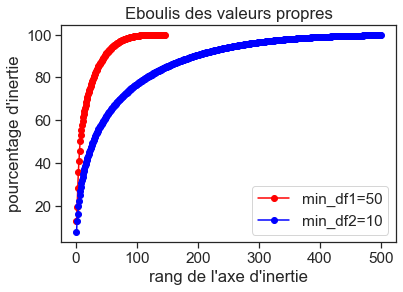

In [28]:
comparer(text_clean, min_df1=50, min_df2=10, n_comp=500)

Comme on peut le voir, le nombre de composantes à garder lors de la réduction de dimensions est à adapter en fonction des features créées lors de la vectorisation. Garder un nombre de features de façon à avoir 90% de la variance expliquée est généralement recommandé. Cependant, on verra que le vocabulaire a été suffisamment raffiné pour que cette étape n'apporte pas de gain significatif.

In [29]:
#  Création d'un dictionnaire liant les tokens à leur valeur tf idf
dicti = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
dicti = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(dicti), orient='index')
dicti.columns = ['tfidf']

Ci dessous les 10 tokens avec le score tfidf le plus faible (mots qui reviennent souvent et donc peu utiles):

In [30]:
dicti.sort_values(by=['tfidf'], ascending=True).head(50)

,tfidf
watch,2.920545
dimension,2.953551
model,2.953551
content,2.967065
design,2.973891
ideal,2.980764
number content,3.015855
specification,3.052223
discount,3.052223
discount genuine,3.052223


Le terme 'watch' apparaît en tête de liste car on a raffiné le vocabulaire de façon à le garder, puisqu'il sera utile pour caractériser des items appartenant à la catégorie... 'watch'.

On peut en profiter pour créer une copie du corpus que l'on appellera 'text_clean2', avec ces tokens moins utiles supprimés afin de voir si il y a un impact sur la qualité du clustering.

In [31]:
stop = dicti.sort_values(by=['tfidf'], ascending=True).head(50).index.tolist()

In [32]:
# On garde le terme 'watch'
stop.remove('watch')

In [33]:
stop

['dimension',
 'model',
 'content',
 'design',
 'ideal',
 'number content',
 'specification',
 'discount',
 'discount genuine',
 'content sale',
 'india flipkartcom',
 'great discount',
 'general brand',
 'cotton',
 'analog',
 'made',
 'analog watch',
 'fabric',
 'detail',
 'package pack',
 'size',
 'pattern',
 'quality',
 'showpiece',
 'baby',
 'name',
 'care',
 'width',
 'water',
 'girl',
 'product free',
 'combo',
 'multicolor',
 'gift',
 'model name',
 'boy',
 'height',
 'men',
 'weight',
 'additional',
 'ceramic',
 'style',
 'combo set',
 'flipkartcom buy',
 'inch',
 'ideal baby',
 'home',
 'woman',
 'round']

On supprime les mots les plus courants en vue d'augmenter la distance inter-clusters.

In [35]:
text_clean2=text_clean.copy()
# Suprression des mots identifiés comme trop courant
for w in stop:
    text_clean2=text_clean2.str.replace(w + " ", "")  # on supprime également l'espace suivant le mot
    text_clean2=text_clean2.str.replace(" " + w, "")  # idem pour l'espace précédent

On peut également regarder les 10 tokens les plus singuliers:

In [34]:
dicti.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
yet fresh,4.866455
porcelain,4.866455
please,4.866455
pick gift,4.866455
come making,4.866455
permanent,4.866455
one toodishwasher,4.866455
mug feature,4.866455
mug 55,4.866455
making perfect,4.866455


### K-Means clustering
On va maintenant réaliser notre clustering sur les descriptions des items à l'aide de KMeans. On commence par rechercher un nombre optimal de clusters:

In [36]:
import os
import time
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [38]:
def train_kmeans(data, n_components, min_df=0.015, max_df=0.15, verbose=1, save_all=False, save=True, name_csv='results_kmeans'):
    model = 'KMeans'
    hyp_param = 'k'
    clusters = list(range(2,31))
    results_km = []
    cwd = os.getcwd()
    path = cwd + '/' + name_csv +  '.csv'
    columns = ['Modèle', 
               'n_comp', 
               'Hyperparamètre', 
               'k clusters', 
               'WCSS', 
               'Silhouette', 
               'Davies_Bouldin', 
               'Calisnki-Har.', 
               'Temps de calcul']
    
    vectorizer = TfidfVectorizer(min_df=min_df,
                             max_df=max_df,
                             ngram_range=(1, 2))
    vz = vectorizer.fit_transform(list(data))
    
    for n in n_components:
        
        # Réduction de dimension
        svd = TruncatedSVD(n_components=n, random_state=12)
        svd_tfidf = svd.fit_transform(vz)
        
        for k in clusters:
            start = time.time()
            
            # Clustering
            KMModel = KMeans(n_clusters=k, 
                             init='k-means++',
                             random_state = 10)
            KMModel.fit(svd_tfidf)
            wcss = round(KMModel.inertia_)
            
            # Scores
            silhouette = round(silhouette_score(svd_tfidf, KMModel.labels_),3)
            davies_bouldin = round(davies_bouldin_score(svd_tfidf, KMModel.labels_),3)
            calinski_harabasz = round(calinski_harabasz_score(svd_tfidf, KMModel.labels_))
            temps = round(time.time() - start)
            
            # Enregistrement des résultats
            results_km.append([model, n, hyp_param, k, wcss, silhouette , davies_bouldin, calinski_harabasz, temps])
            if verbose == 1:
                print("model =", model, "    n_comp = ", n,  "    clusters=", k, '\n',
                      "within cluster SS = ", wcss, '\n',
                      "silhouette_score =", silhouette,'\n',
                      "davies_bouldin_score =", davies_bouldin,'\n',
                      "calinski_harabasz_score =", calinski_harabasz,'\n',
                      "temps de calcul: ", temps,
                      "\n\n", "-------------------------------", "\n")
                
            # Sauvegarde au format .csv après chaque ligne de résultat (protection contre les crashs)
            if save_all == True:
                df = pd.DataFrame(results_km, columns=columns)
                df.to_csv(path)
    df = pd.DataFrame(results_km, columns=columns)
    
    # Sauvegarde au format .csv
    if save==True:
        df.to_csv(path)
    return df

In [39]:
%%time
n_components = [200, 250, 346]
results_kmeans = train_kmeans(text_clean, n_components, save_all=True, name_csv='results_kmeans')
results_kmeans

model = KMeans     n_comp =  200     clusters= 2 
 within cluster SS =  880 
 silhouette_score = 0.067 
 davies_bouldin_score = 2.421 
 calinski_harabasz_score = 70 
 temps de calcul:  0 

 ------------------------------- 

model = KMeans     n_comp =  200     clusters= 3 
 within cluster SS =  832 
 silhouette_score = 0.098 
 davies_bouldin_score = 2.122 
 calinski_harabasz_score = 67 
 temps de calcul:  0 

 ------------------------------- 

model = KMeans     n_comp =  200     clusters= 4 
 within cluster SS =  795 
 silhouette_score = 0.12 
 davies_bouldin_score = 2.036 
 calinski_harabasz_score = 63 
 temps de calcul:  0 

 ------------------------------- 

model = KMeans     n_comp =  200     clusters= 5 
 within cluster SS =  767 
 silhouette_score = 0.127 
 davies_bouldin_score = 2.378 
 calinski_harabasz_score = 59 
 temps de calcul:  0 

 ------------------------------- 

model = KMeans     n_comp =  200     clusters= 6 
 within cluster SS =  739 
 silhouette_score = 0.144 
 

model = KMeans     n_comp =  250     clusters= 10 
 within cluster SS =  680 
 silhouette_score = 0.185 
 davies_bouldin_score = 2.219 
 calinski_harabasz_score = 47 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  250     clusters= 11 
 within cluster SS =  676 
 silhouette_score = 0.182 
 davies_bouldin_score = 2.731 
 calinski_harabasz_score = 43 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  250     clusters= 12 
 within cluster SS =  658 
 silhouette_score = 0.193 
 davies_bouldin_score = 2.618 
 calinski_harabasz_score = 43 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  250     clusters= 13 
 within cluster SS =  648 
 silhouette_score = 0.182 
 davies_bouldin_score = 2.607 
 calinski_harabasz_score = 41 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  250     clusters= 14 
 within cluster SS =  631 
 silhouette_score = 0.

model = KMeans     n_comp =  346     clusters= 18 
 within cluster SS =  609 
 silhouette_score = 0.198 
 davies_bouldin_score = 1.891 
 calinski_harabasz_score = 36 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  346     clusters= 19 
 within cluster SS =  598 
 silhouette_score = 0.214 
 davies_bouldin_score = 1.92 
 calinski_harabasz_score = 36 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  346     clusters= 20 
 within cluster SS =  597 
 silhouette_score = 0.21 
 davies_bouldin_score = 1.868 
 calinski_harabasz_score = 34 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  346     clusters= 21 
 within cluster SS =  578 
 silhouette_score = 0.221 
 davies_bouldin_score = 2.184 
 calinski_harabasz_score = 35 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  346     clusters= 22 
 within cluster SS =  567 
 silhouette_score = 0.22

,Modèle,n_comp,Hyperparamètre,k clusters,WCSS,Silhouette,Davies_Bouldin,Calisnki-Har.,Temps de calcul
0,KMeans,200,k,2,880,0.067,2.421,70,0
1,KMeans,200,k,3,832,0.098,2.122,67,0
2,KMeans,200,k,4,795,0.120,2.036,63,0
3,KMeans,200,k,5,767,0.127,2.378,59,0
4,KMeans,200,k,6,739,0.144,2.404,57,0
...,...,...,...,...,...,...,...,...,...
82,KMeans,346,k,26,547,0.227,1.796,32,1
83,KMeans,346,k,27,526,0.249,1.852,33,1
84,KMeans,346,k,28,522,0.248,1.850,33,1
85,KMeans,346,k,29,523,0.220,1.745,31,1


In [40]:
#results_kmeans = pd.read_csv('results_kmeans.csv')

In [154]:
def tracer_scores(df_resultats):
    # Réarrangement des colonnes
    scores = ['WCSS', 'Silhouette', 'Davies_Bouldin', 'Calisnki-Har.']
    columns = ['n_comp', 'k clusters', 'score_value', 'score_type']
    df0 = df_resultats[['n_comp', 'k clusters']]
    df_res = pd.DataFrame(columns=columns)
    for s in scores:
        df = df0.copy()
        df['score_value'] = df_resultats[s].copy()
        df['score_type'] = s
        df_res = pd.concat([df_res, df], ignore_index=True)

    df_res = df_res.astype({'n_comp': 'int32',
                  'k clusters': 'int32',
                  'score_value':'float'})

    # Graphes scores
    sns.relplot(
        data=df_res, kind="line",
        x="k clusters", 
        y="score_value", 
        hue="n_comp",
        facet_kws=dict(sharey=False),
        col="score_type",
        col_wrap=2,
        linewidth =3
    )

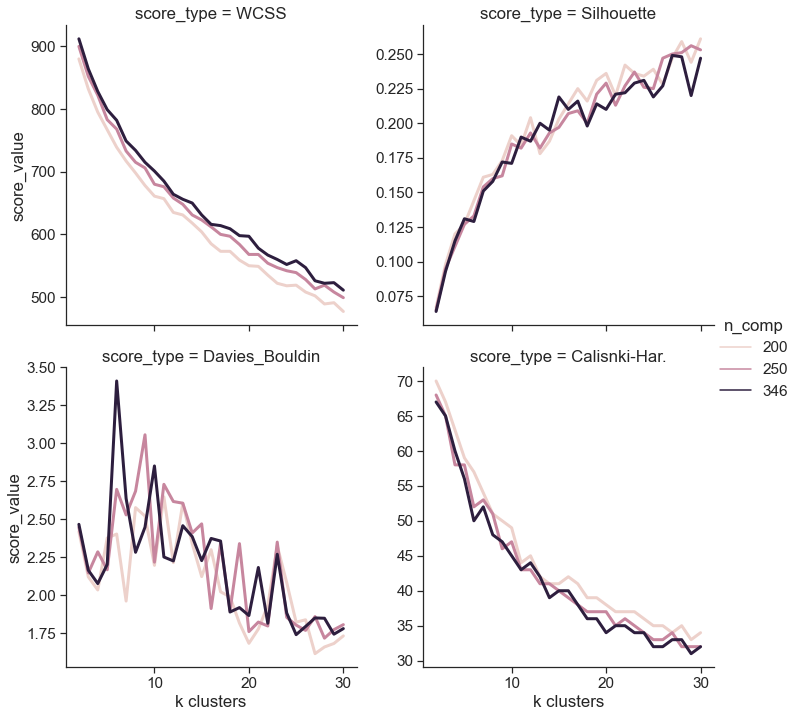

In [42]:
tracer_scores(results_kmeans)

Le graphe ci-dessus représente différents scores de validation interne, en fonction du nombre de clusters. Le nombre de clusters optimal est défini selon le type de score par:
- WCSS: au niveau du coude
- silhouette: le maximum
- Davies Bouldin: le minimum
- Calinski et Harabasz: le maximum

Comme on peut le voir ici il est impossible de déterminer un nombre de clusters optimal selon ces critères sur la plage de k étudiée. 

Essayons avec notre corpus plus raffiné:

In [43]:
%%time
n_components = [200, 250, 346]
results_kmeans = train_kmeans(text_clean2, n_components, save_all=True, name_csv='results_kmeans')
results_kmeans

model = KMeans     n_comp =  200     clusters= 2 
 within cluster SS =  899 
 silhouette_score = 0.066 
 davies_bouldin_score = 2.352 
 calinski_harabasz_score = 68 
 temps de calcul:  0 

 ------------------------------- 

model = KMeans     n_comp =  200     clusters= 3 
 within cluster SS =  861 
 silhouette_score = 0.091 
 davies_bouldin_score = 2.16 
 calinski_harabasz_score = 59 
 temps de calcul:  0 

 ------------------------------- 

model = KMeans     n_comp =  200     clusters= 4 
 within cluster SS =  833 
 silhouette_score = 0.106 
 davies_bouldin_score = 2.355 
 calinski_harabasz_score = 52 
 temps de calcul:  0 

 ------------------------------- 

model = KMeans     n_comp =  200     clusters= 5 
 within cluster SS =  808 
 silhouette_score = 0.121 
 davies_bouldin_score = 2.524 
 calinski_harabasz_score = 48 
 temps de calcul:  0 

 ------------------------------- 

model = KMeans     n_comp =  200     clusters= 6 
 within cluster SS =  791 
 silhouette_score = 0.13 
 d

model = KMeans     n_comp =  250     clusters= 10 
 within cluster SS =  732 
 silhouette_score = 0.163 
 davies_bouldin_score = 2.554 
 calinski_harabasz_score = 38 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  250     clusters= 11 
 within cluster SS =  729 
 silhouette_score = 0.143 
 davies_bouldin_score = 2.3 
 calinski_harabasz_score = 35 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  250     clusters= 12 
 within cluster SS =  711 
 silhouette_score = 0.162 
 davies_bouldin_score = 2.558 
 calinski_harabasz_score = 35 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  250     clusters= 13 
 within cluster SS =  687 
 silhouette_score = 0.182 
 davies_bouldin_score = 2.323 
 calinski_harabasz_score = 36 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  250     clusters= 14 
 within cluster SS =  693 
 silhouette_score = 0.17

model = KMeans     n_comp =  346     clusters= 18 
 within cluster SS =  641 
 silhouette_score = 0.196 
 davies_bouldin_score = 2.665 
 calinski_harabasz_score = 32 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  346     clusters= 19 
 within cluster SS =  617 
 silhouette_score = 0.228 
 davies_bouldin_score = 1.741 
 calinski_harabasz_score = 33 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  346     clusters= 20 
 within cluster SS =  618 
 silhouette_score = 0.224 
 davies_bouldin_score = 1.834 
 calinski_harabasz_score = 32 
 temps de calcul:  1 

 ------------------------------- 

model = KMeans     n_comp =  346     clusters= 21 
 within cluster SS =  606 
 silhouette_score = 0.229 
 davies_bouldin_score = 1.909 
 calinski_harabasz_score = 32 
 temps de calcul:  2 

 ------------------------------- 

model = KMeans     n_comp =  346     clusters= 22 
 within cluster SS =  608 
 silhouette_score = 0.

,Modèle,n_comp,Hyperparamètre,k clusters,WCSS,Silhouette,Davies_Bouldin,Calisnki-Har.,Temps de calcul
0,KMeans,200,k,2,899,0.066,2.352,68,0
1,KMeans,200,k,3,861,0.091,2.160,59,0
2,KMeans,200,k,4,833,0.106,2.355,52,0
3,KMeans,200,k,5,808,0.121,2.524,48,0
4,KMeans,200,k,6,791,0.130,2.395,44,0
...,...,...,...,...,...,...,...,...,...
82,KMeans,346,k,26,556,0.250,2.172,31,2
83,KMeans,346,k,27,559,0.251,1.827,30,2
84,KMeans,346,k,28,563,0.250,1.782,28,2
85,KMeans,346,k,29,535,0.264,2.194,30,2


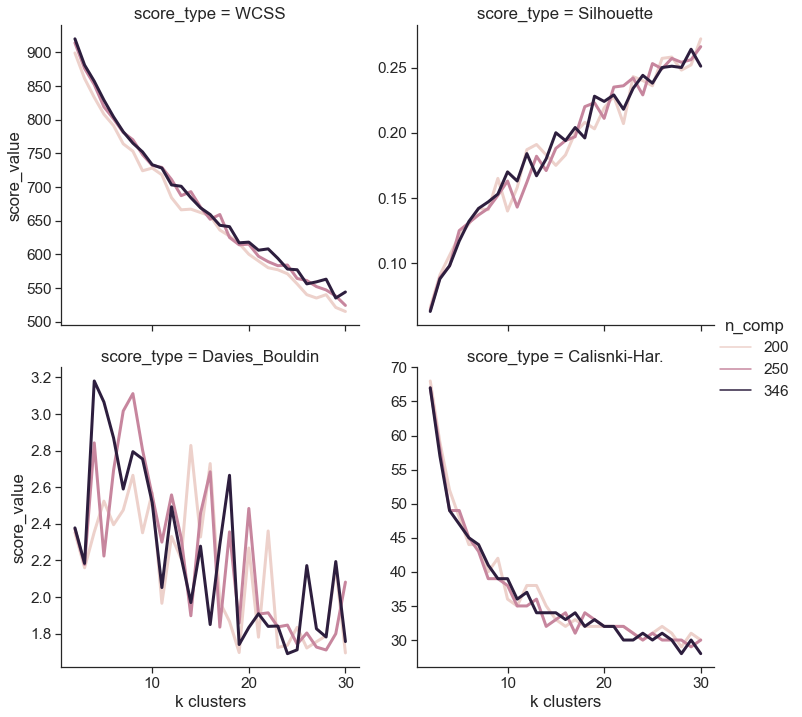

In [44]:
tracer_scores(results_kmeans)

Les résultats avec le corpus plus raffiné ne sont pas meilleurs.

Tentons maintenant de représenter un nombre de clusters similaire aux catégories des objets, et d'en réaliser une représentation 2D en utilisant t-SNE.

On affichera en même temps les 10 n-grams les plus représentatif par cluster.

In [6]:
# Chargement de Bokeh
output_notebook()

Loading BokehJS ...

In [7]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#194196", "#d27c88", "#36422b", "#b68f79"])

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
from bokeh.models import CategoricalColorMapper

In [18]:
def clustering(text, k=7, min_df=0.015, max_df=0.15, n_comp=300, n_gram=2, tol_km=1e-4, perplexity=30, early_exaggeration=12, learning_rate=200):
    """
    Fonction réalisant un clustering de type KMeans sur les descriptions
    produits après réduction de dimensions par TruncatedSVD.
    Affiche également:
    - les 10 n-grammes les plus représentatif par cluster
    - une représentation 2D des clusters via t-SNE
    - la correspondance cluster/catégories
    - le temps de calcul
    """
    
    start = time.time()  # initialisation temps de calcul
    
    # Vectorizer de type tf-idf
    vectorizer = TfidfVectorizer(
                             min_df=min_df,
                             max_df=max_df,
                             ngram_range=(1, n_gram))
    vz = vectorizer.fit_transform(list(text))
    
    # Clustering KMeans
    km = KMeans(n_clusters=k,
                         init='k-means++',
                         verbose=0, 
                         max_iter=1000,
                         tol=tol_km,
                         random_state=12)
    
    # Réduction de dimensions si n spécifié différent de zéro
    if n_comp!= 0:
        # Pour une matrice creuse il est recommandé d'utiliser  
        # TruncatedSVD pour réduire le nombre de dimensions
        svd = TruncatedSVD(n_components=n_comp, random_state=12)
        vz = svd.fit_transform(vz)
     
    km = km.fit(vz)
    km_clusters = km.predict(vz)
    km_distances = km.transform(vz)
    
    temps = time.time() - start  # 
    
    # Affichage des 10 n-grammes les plus représentatifs par cluster
    centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    
    for i in range(k):
        print("Cluster %d:" % i)
        aux = ''
        for j in centroids[i, :10]:
            aux += terms[j] + ' | '
        print(aux)
        print()
     
    # Création du modèle t-SNE
    tsne_model = TSNE(n_components=2, 
                      verbose=1, 
                      random_state=12, 
                      n_iter=1000,
                      perplexity=perplexity,
                      early_exaggeration=early_exaggeration,
                      learning_rate=learning_rate)

    # Réduction de dimension à 2 via t-SNE
    tsne_kmeans = tsne_model.fit_transform(km_distances)

    # Préparation du plot
    kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
    kmeans_df['cluster'] = km_clusters
    kmeans_df['description'] = df['description']
    kmeans_df['category'] = categories(df, unique=False)

    # Représentation 2D des clusters
    plot_kmeans = bp.figure(plot_width=700, plot_height=600,
                            title="KMeans clustering of the description",
        tools="pan,wheel_zoom,box_zoom,reset,hover",
        x_axis_type=None, y_axis_type=None, min_border=1)

    source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'],
                                        color=colormap[km_clusters],
    #                                     description=kmeans_df['description'],
                                        category=kmeans_df['category'],
                                        cluster=kmeans_df['cluster']))

    plot_kmeans.scatter(x='x', y='y', color='color', source=source)
    hover = plot_kmeans.select(dict(type=HoverTool))
    hover.tooltips={
    #     "description": "@description", 
        "category": "@category", 
        "cluster":"@cluster" }
    show(plot_kmeans)

    # Correspondance entre clusters et catégories
    m_conf = kmeans_df.groupby(['cluster', 'category']).size().reset_index().pivot(columns='category', index='cluster', values=0)
    m_conf.plot(kind='bar', stacked=True, figsize=(16,8), title="Correspondance entre clusters et catégories")
    
    print(f'Temps de calcul: {temps:.2f}s')
    
    return kmeans_df

Cluster 0:
usb | light | led | led light | usb led | fan | hub | flexible | usb usb | usb hub | 

Cluster 1:
baby | baby girl | girl | detail | fabric | dress | baby boy | cotton | sleeve | boy | 

Cluster 2:
set online | combo set | combo | flipkartcom buy | buy denver | denver | online 350 | 350 flipkartcom | adidas | set combo | 

Cluster 3:
product free | towel | kadhai | cotton | inch | multicolor | single | laptop | warranty | cover | 

Cluster 4:
mug | ceramic | ceramic mug | prithish | coffee | perfect | rockmantra | one | mug best | coffee mug | 

Cluster 5:
showpiece | cm best | showpiece cm | handicraft | buddha | statue | brass | ganesha | gift | exotic india | 

Cluster 6:
watch | analog | analog watch | men | watch men | discount genuine | discount | great discount | india flipkartcom | watch woman | 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.013s...
[t-SNE] Computed neighbors for 1050 samples in 0.067s...
[t-SNE] Computed conditional pr

Temps de calcul: 1.20s


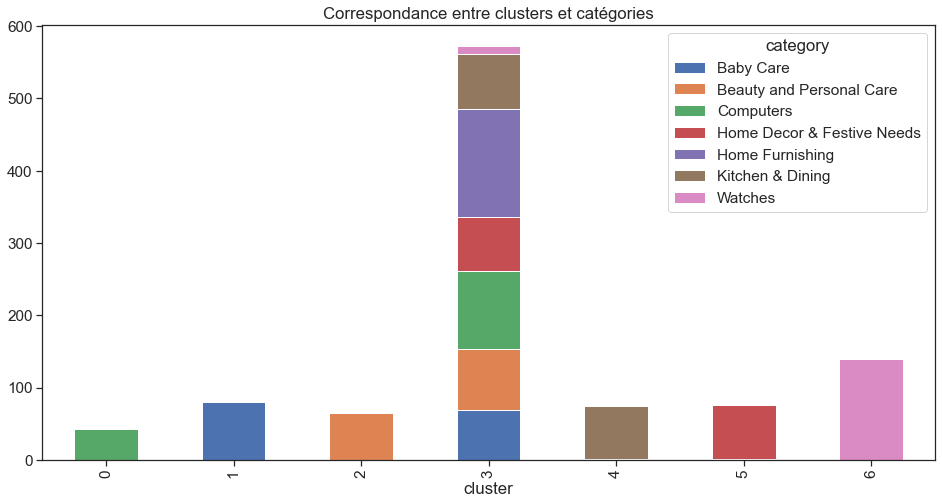

In [19]:
km_df = clustering(text_clean, k=7, min_df=5, max_df=0.15, n_comp=0, tol_km=1e-4, perplexity=30, early_exaggeration=12, learning_rate=200)

Tous les clusters à part le numéro 3 correspondent à une catégorie particulière, cela est cohérent avec les n-grams les plus représentatifs par cluster. Comme on le voit sur la représentation 2D, il y a une grande proportion d'items dans le cluster 3 qui n'arrive pas à être départagée.

In [54]:
# cwd = os.getcwd()
# path = cwd + '/' + 'km_df_best_results' +  '.csv'
# km_df.to_csv(path)

Après un grand nombre d'essais sur les divers paramètres de **k**, **min_df**, **max_df** et **n_gram**, et après avoir essayé d'enlever les mots les plus courants qui pourraient rapprocher différents items sous une seule catégorie (tentative avec text_clean2), ou en utilisant une racination à la place de la lemmatisation (tentative avec text_clean_rac) il semble impossible de départager les items du cluster 3. 

Toutes ces tentatives ont été supprimées par souci de lecture.

In [55]:
# Essai avec racination
# km_df = clustering(text_clean_rac, k=7, min_df=5, max_df=0.15, n_comp=0, tol_km=1e-4, perplexity=30, early_exaggeration=12, learning_rate=200)

In [56]:
km_df[km_df['cluster']==3].head()

,x,y,cluster,description,category
0,-8.506226,1.354417,3,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",Home Furnishing
1,-6.426291,-12.851891,3,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",Baby Care
2,-6.781438,-13.098475,3,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM 360 Type Face Towel Set Model Name SHUVAM20PCFTSETASSORTED Ideal For Boys, Girls, Men, Women Model ID SHUVAM20PCFTSETASSORTED Size small Color Assorted Dimensions Weight 350 g Length 9 inch Width 9 inch In the Box Number of Contents in Sales Package 20 Sales Package 20 PIECE FACE TOWEL SET",Baby Care
3,-8.556483,-9.818353,3,"Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet (1 Bedsheet,2 Pillow Cover, Multicolor) General Brand SANTOSH ROYAL FASHION Machine Washable Yes Type Flat Material Cotton Model Name Gold Design Royal Cotton Printed Wedding & Gifted Double Bedsheet With 2 Pillow cover Model ID goldbedi-38 Color Multicolor Size King Fabric Care Machine Wash, Do Not Bleach Dimensions Flat Sheet Width 90 inch / 230 cm Fitted Sheet Width 228 cm Pillow Cover Width 16 inch / 43 cm Pillow Cover Length 28 inch / 72 cm Fitted Sheet Depth 280 cm Fitted Sheet Lengt

Il est difficile de trouver une expliquation au phénomène.

### Approche supervisée

Entraînons notre jeu de données sur un classifieur de type Random Forest, couplé à une validation croisée à 5 folds. Dans cette approche on considère les catégories de niveau 0 comme les étiquettes à prédire. Comme on l'a vu, les sous-catégories sont souvent trop peu renseignées pour être efficaces.

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [62]:
y = categories(df, unique=False)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(text_clean, y, test_size=0.15, random_state=42)

In [76]:
# Vectorisation du corpus
tfidf = TfidfVectorizer(
    min_df=0.015,
    max_df = 0.1,
    ngram_range=(1, 3))

X_train_idf = tfidf.fit_transform(X_train)  # on prend soin de ne fit que sur les données d'entraînement
X_test_idf = tfidf.transform(X_test)

In [78]:
start=time.time()

# Classifieur RandomForest avec validation croisée
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [30, 35, 40],
    'max_depth' : [50, 55, 60],
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_idf, y_train)

print('Paramètres optimaux:', CV_rfc.best_params_)
y_pred = CV_rfc.best_estimator_.predict(X_test_idf)

temps = time.time()-start

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Temps de calcul: {temps:.2f}s")

Paramètres optimaux: {'max_depth': 55, 'n_estimators': 35}
Accuracy: 0.93
Temps de calcul: 5.32s


Random Forest entraîné avec les paramètres ci-dessus permet d'atteindre une précision de 93% sur un jeu de données inconnu.

# Données Images
## Feature extraction avec ORB

In [113]:
import cv2
import os
import random
import pylab as pl
from sklearn.metrics import confusion_matrix,accuracy_score

import time

In [56]:
# Chemin des images
image_paths = 'Images/'+ df['image']
# Labels des images basés sur les catégories
image_labels=categories(df, level=0, unique =False)
# Split des données en test and train sets
image_paths_train, image_paths_test, y_train, y_test = train_test_split(image_paths, image_labels, test_size=0.15, random_state=42)

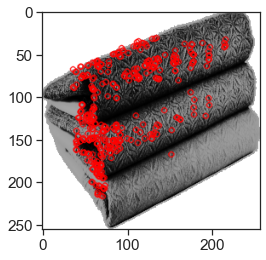

Descripteurs :  (390, 32)

[[ 91 169  58 ...   2  35 218]
 [ 79 125 242 ... 221 241 223]
 [166 137 118 ... 255 243 149]
 ...
 [ 69  75 197 ... 177  65 161]
 [  1 158  25 ... 192 193 169]
 [  7  22 229 ... 228 129 245]]


In [200]:
# Affichage des descripteurs ORB
orb = cv2.ORB_create(500)
image = cv2.imread(image_paths[1],0) # convert in gray
image = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)  # resize images 

image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = orb.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image, color =(255,0,0))
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

- L'image contient 390 descripteurs (valeur max par défaut: 500)
- Chaque descripteur possède 32 composantes

# Preprocessing des images pour ORB

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("orb_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("orb_keypoints_all") qui sera utilisée pour créer les clusters de descripteurs

In [314]:
# identification of key points and associated descriptors
import time, cv2
orb_keypoints = []
temps1=time.time()
orb = cv2.ORB_create(500)

no_descr_count = 0
des_list =[]
for image_path in image_paths :
    image = cv2.imread(image_path,0) # convert in gray
    image = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)  # resize images 
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)   # equalize image histogram
    kp = orb.detect(image, None)
        
    # Dans le cas où aucun descripteur n'est trouvé:
    if len(kp) < 1:
        no_descr = np.zeros((1, orb.descriptorSize()), np.int)
        keypoints,descriptor= (kp, no_descr)
        no_descr_count = no_descr_count +1
    # Sinon on ajoute le descripteur
    else:
        keypoints,descriptor= orb.compute(image, kp)
    des_list.append((image_path,descriptor)) 

descr_by_img = np.asarray(des_list)

# On stack les descripteurs sous forme verticale
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))  # Stacking the descriptors

# orb_keypoints_by_img = np.asarray(des_list)
# orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", descriptors.shape)

duration1=time.time()-temps1
print("temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")

C:\Users\admin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Nombre de descripteurs :  (425731, 32)
temps de traitement ORB descriptor :            35.86 secondes


In [229]:
# Nombre de fois où aucun descripteur n'est trouvé:
no_descr_count

0

#### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [234]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(descriptors)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, 
                init_size=3*k, 
                random_state=10,
                batch_size =1024
               )
kmeans.fit(descriptors)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  652
Création de 652 clusters de descripteurs ...
temps de traitement kmeans :            66.00 secondes


#### Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [236]:
# Creation of histograms (features)
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [254]:
len(descr_by_img)

1050

In [255]:
temps1=time.time()

# Creation of a matrix of histograms
hist_vectors=[]

for i in range(len(descr_by_img)):
# for i, image_desc in enumerate(descr_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, descr_by_img[i][1], i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             5.34 secondes


#### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [258]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 652)
Dimensions dataset après réduction PCA :  (1050, 532)


#### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [270]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=20, 
                     n_iter=2000, random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = categories(df, unique=False)
print(df_tsne.shape)

(1050, 3)


#### Analyse visuelle : affichage T-SNE selon catégories d'images

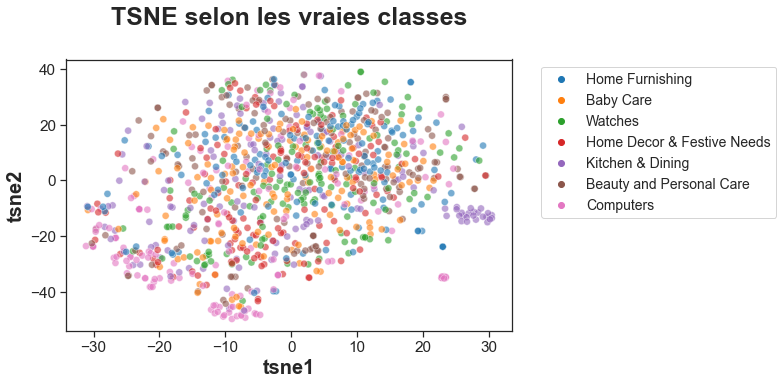

In [271]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 14},bbox_to_anchor=(1.05, 1), loc='upper left') 

plt.show()


#### Analyse mesures : similarité entre catégories et clusters
#####  Création de clusters à partir du T-SNE

In [272]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


####  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.15 reste faible

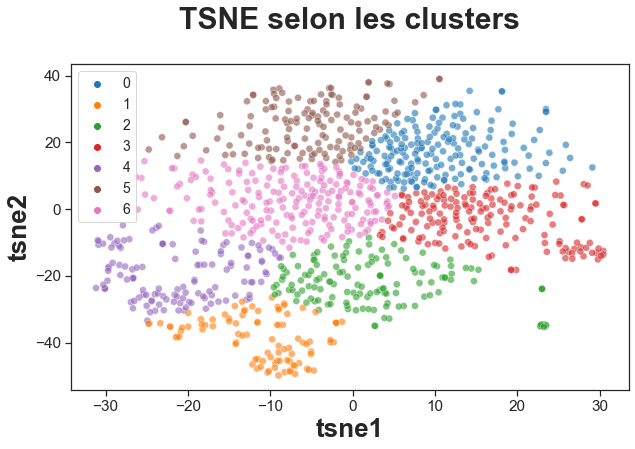

ARI :  0.023465325313388605


In [275]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = categories(df,unique=0)
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [276]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    188
1     94
2    135
3    167
4    126
5    140
6    200
Name: class, dtype: int64

In [295]:
list1=labels.tolist()
list2=cls.labels_.tolist()

results = pd.DataFrame({'category':list1, 'cluster':list2})
results

,category,cluster
0,Home Furnishing,0
1,Baby Care,6
2,Baby Care,0
3,Home Furnishing,3
4,Home Furnishing,3
...,...,...
1045,Baby Care,3
1046,Baby Care,6
1047,Baby Care,2
1048,Baby Care,3


<AxesSubplot:title={'center':'Correspondance entre clusters et catégories'}, xlabel='cluster'>

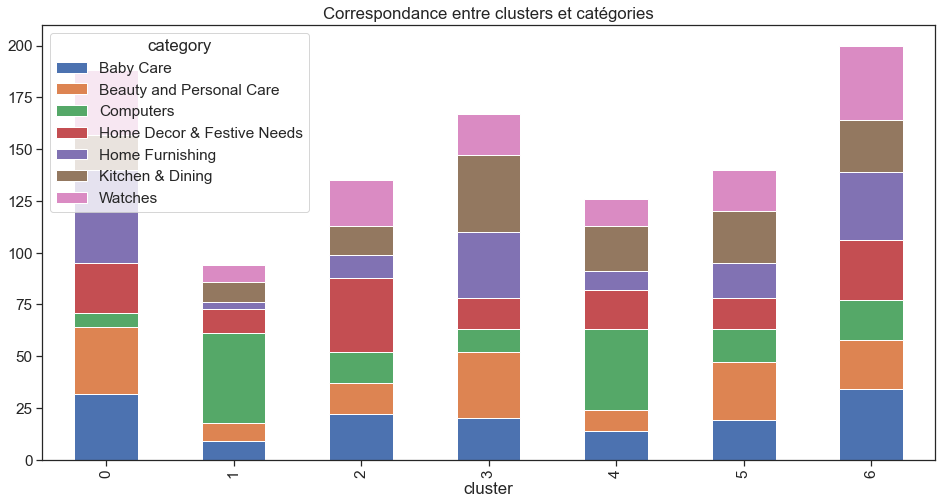

In [296]:
# Correspondance entre clusters et catégories
m_conf = results.groupby(['category', 'cluster']).size().reset_index().pivot(columns='category', index='cluster', values=0)
m_conf.plot(kind='bar', stacked=True, figsize=(16,8), title="Correspondance entre clusters et catégories")


Le clustering réalisé sur les descripteurs trouvés par ORB est très peu satisfaisant...

## VGG16 transfer learning

On peut également utiliser un réseau de neurones convolutionnel pré-entraîné, dont on entraînera que la dernière couche. Ici on utilisera dans un  premier temps VGG16.

In [50]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [9]:
# Read input images and assign labels based on folder names
# print(os.listdir("images/"))

SIZE = 256  #Resize images

In [ ]:
# Chemin des images
image_paths = 'Images/'+ df['image']
image_labels=categories(df, level=0, unique =False)

Label de l'image 15: Watches


-1

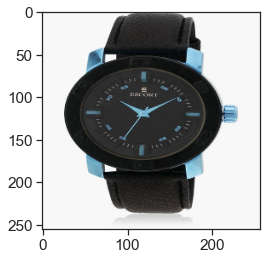

In [10]:
num_img = 15

img = cv2.imread(image_paths[num_img])
img = cv2.resize(img, (SIZE, SIZE))

print(f"Label de l'image {num_img}: {image_labels[num_img]}")

plt.imshow(img)
# cv2.imshow('Image', img)
cv2.waitKey(0) 

In [12]:
# Split data into test and train datasets
image_paths_train, image_paths_test, train_labels, test_labels = train_test_split(image_paths, image_labels, test_size=0.15, random_state=42)

In [13]:
def liste_images(image_paths):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        images.append(img)
    return images

In [14]:
train_images = liste_images(image_paths_train)
test_images = liste_images(image_paths_test)

Label de l'image 442: Baby Care


-1

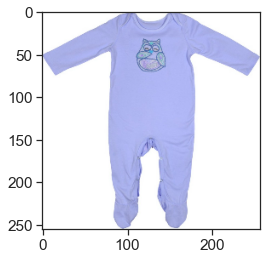

In [15]:
num_img = 442

img = cv2.imread(image_paths_test[num_img])
img = cv2.resize(img, (SIZE, SIZE))

print(f"Label de l'image {num_img}: {image_labels[num_img]}")

plt.imshow(img)
# cv2.imshow('Image', img)
cv2.waitKey(0) 

In [16]:
#Convert lists to arrays    
train_images = np.array(train_images)
test_images = np.array(test_images)

In [17]:
#Encode labels from text to integers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [18]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
X_train, y_train, X_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [19]:
# Normalize pixel values to between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

In [20]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [21]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [22]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(X_train)

In [23]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [24]:
X_for_RF = features #This is our X input to RF

In [ ]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [56]:
start = time.time()

# Classifieur RandomForest avec validation croisée
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [55, 60, 65],
    'max_depth' : [20, 25, 30],
}

RF_model = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
RF_model.fit(X_for_RF, y_train)

temps = time.time() - start
print('Paramètres optimaux:', RF_model.best_params_)
print(f'Temps de calcul: {temps:.2f} s')

RF_model = RF_model.best_estimator_
RF_model.fit(X_for_RF, y_train)

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)

#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

#Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Paramètres optimaux: {'max_depth': 25, 'n_estimators': 60}
Temps de calcul: 104.98 s 104.9823899269104
Accuracy =  0.7278481012658228


In [29]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

<AxesSubplot:>

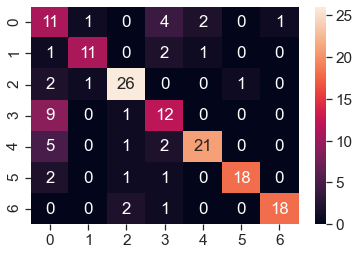

In [30]:
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

In [85]:
def test_random_image(X_test, model, classifier):
    n=np.random.randint(0, X_test.shape[0])
    img = X_test[n]
    plt.imshow(img)
    input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
    input_img_feature=VGG_model.predict(input_img)
    input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
    prediction_RF = RF_model.predict(input_img_features)[0] 
    prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
    print("The prediction for this image is: ", prediction_RF)
    print("The actual label for this image is: ", test_labels.reset_index(drop=True)[n])

The prediction for this image is:  ['Watches']
The actual label for this image is:  Watches


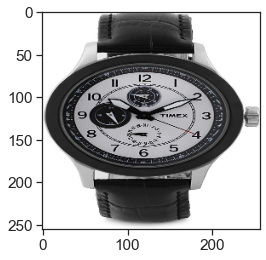

In [47]:
# Test sur une image prise au hasard
n=np.random.randint(0, X_test.shape[0])
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels.reset_index(drop=True)[n])

In [81]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
# VGG_model.summary()  #Trainable parameters will be 0

In [82]:
num_of_cat = 7
x = VGG_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
# x = Dense(256, activation='relu')(x)
x = Dense(num_of_cat, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=VGG_model.input, outputs=x)
# model.build()
transfer_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [84]:
start = time.time()

transfer_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc'])

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

transfer_model.fit(X_train, y_train, epochs=5, validation_split=0.15, callbacks=[es_callback])

temps = time.time()-start
print(f'Temps de calcul: {temps:.2f} s')

Epoch 1/5
24/24 [==============================] - 823s 34s/step - loss: 1.8912 - acc: 0.4305 - val_loss: 0.7498 - val_acc: 0.7761
Epoch 2/5
24/24 [==============================] - 799s 34s/step - loss: 0.3453 - acc: 0.8803 - val_loss: 0.5928 - val_acc: 0.8209
Epoch 3/5
24/24 [==============================] - 807s 34s/step - loss: 0.0846 - acc: 0.9878 - val_loss: 0.6061 - val_acc: 0.8433
Epoch 4/5
24/24 [==============================] - 805s 34s/step - loss: 0.0325 - acc: 0.9981 - val_loss: 0.5629 - val_acc: 0.8657
Epoch 5/5
24/24 [==============================] - 791s 33s/step - loss: 0.0174 - acc: 1.0000 - val_loss: 0.5388 - val_acc: 0.8582
Temps de calcul: 4042.67 s


In [93]:
# Sauvegarde du modèle
# path = os.getcwd() + '/model_vgg16_transfer'
# transfer_model.save(path)

INFO:tensorflow:Assets written to: C:\Users\admin\Desktop\Luc\P6\Flipkart/model_vgg16_transfer\assets


In [ ]:
# Chargement du modèle
# model = keras.models.load_model('path/to/location')

In [96]:
transfer_model.evaluate(X_test,y_test)

5/5 [==============================] - 237s 42s/step - loss: 0.6108 - acc: 0.7785


[0.6107669472694397, 0.7784810066223145]

On obtient une accuracy de 78% sur le jeu de test.

## CNN transfer learning 2
Une autre méthode de transfer learning, plus rapide et précise.

In [ ]:
# pip install tensorflow_hub

In [299]:
import numpy as np
import cv2

import PIL.Image
import os

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelEncoder

In [300]:
# Chemin des images
image_paths = 'Images/'+ df['image']

In [301]:
IMAGE_SHAPE=(224,224)

# Création d'un modèle Keras
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4",
                  input_shape=IMAGE_SHAPE+(3,))
])

In [302]:
image_labels=categories(df, level=0)

In [303]:
# Encodage des labels
le = LabelEncoder()
y= le.fit_transform(categories(df, level=0, unique=False))

In [304]:
X= []

for image in image_paths:
    img = cv2.imread(str(image))
    resized_img = cv2.resize(img,(224,224))
    X.append(resized_img)

X = np.array(X)
y = np.array(y)

In [306]:
# Scaling
X_scaled = X/255.0

In [307]:
# On crée un jeu d'entraînement et un jeu de test
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

In [308]:
# Dimensions d'une image
X[0].shape

(224, 224, 3)

In [309]:
# Téléchargement du CNN pré-entraîné
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224,224,3),
    trainable=False)  # on garde les couches pré-entraînées telles quel

In [310]:
num_of_cat = 7

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(num_of_cat)  # ajout de la couche fully connected à entraîner
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


In [313]:
temps1=time.time()

# Entraînement de la couche fully connected avec validation croisée
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(X_scaled_train, y_train, epochs=5, validation_split=0.15, callbacks=[es_callback])

duration1=time.time()-temps1
print("Temps d'entraînement : ", "%15.2f" % duration1, "secondes")

Epoch 1/5
24/24 [==============================] - 46s 2s/step - loss: 0.3105 - acc: 0.9077 - val_loss: 0.4277 - val_acc: 0.8657
Epoch 2/5
24/24 [==============================] - 35s 1s/step - loss: 0.2384 - acc: 0.9327 - val_loss: 0.4404 - val_acc: 0.8358
Epoch 3/5
24/24 [==============================] - 34s 1s/step - loss: 0.1869 - acc: 0.9565 - val_loss: 0.4592 - val_acc: 0.8433
Epoch 4/5
24/24 [==============================] - 33s 1s/step - loss: 0.1529 - acc: 0.9670 - val_loss: 0.4201 - val_acc: 0.8433
Epoch 5/5
24/24 [==============================] - 33s 1s/step - loss: 0.1245 - acc: 0.9828 - val_loss: 0.4454 - val_acc: 0.8507
Temps d'entraînement :           193.29 secondes


In [312]:
model.evaluate(X_scaled_test,y_test)

5/5 [==============================] - 7s 1s/step - loss: 0.6357 - acc: 0.8038


[0.635681688785553, 0.8037974834442139]

On obtient 80% de prédictions correctes sur notre jeu de données test, pour un temps de calcul minimal (3 minutes).

# Conclusion

On a vu que le clustering non supervisé donnait des résultats peu probants sur ce jeu de données. 

Par contre, une classification supervisée donne des résultats satisfaisants, en particulier sur les **descriptions** des objets puisqu'on on atteint un taux de classification correct de **93%**.

Sur la partie images la méthode la plus performante est le **transfer learning** qui permet de bénéficier des poids d'un réseau de neurones convolutif pré-entraîné et permet un taux de précision jusqu'à **80%** avec un temps d'entraînment minimal d'environ **3 minutes**.